# A model for safety-performance tradeoffs in AI

## Safety and performance production functions

Assume that firms produce safety $S$ and performance $P$ according to CES production functions
$$S(K, L) = A\left(aK^\rho + (1-a)L^\rho\right)^{\mu / \rho}$$
$$P(K, L) = B\left(bK^\sigma + (1-b)L^\sigma\right)^{\nu / \sigma}$$
where $K$ is capital (interpet as computational power in this case), and $L$ is labor (interpret as programmers).

Why CES production? This is a form that is pretty but is also not too inconvenient to work with mathematically. All the parameters have pretty interpretable meanings. The main argument against using this form is that the elasticity of substitution may not be the same for all $(K, L)$ -- capital and labor may act like substitutes sometimes and complements other times -- but I think this is at least a good local approximation. We can consider both cases, at any rate.

What do parameters mean?

* $A, B > 0$ are productivity params. If they're higher, firms are better at producing safety/performance.
* $a, b \in [0,1]$ are share parameters, denoting how important capital is for production, relative to labor. E.g., if $a > 0.5$, then capital is more efficient (per unit) for production than is labor.
* $\rho, \sigma$ are elasticity parameters. The elasticity of substition is $1/(1-\rho)$ for $S$ and $1/(1-\sigma)$ for $P$. E.g, if $\rho < 1$, then capital and labor are substitutes for production of safety.
* $\mu, \nu > 0$ determine returns to scale. Returns to scale for $S$ (or $P$) are decreasing iff $\mu$ (or $\nu$) is less than 1.

A comment here: typically in econ we assume decreasing returns to scale, but returns to scale may conceivably not be decreasing in this case, and such a scenario would be quite worrisome, so we probably shouldn't ignore it here.

## The net payoff function

We'll think about a single-agent case first. Assume that the firm's net payoff is
$$\pi(K,L) = \frac{S}{1+S} R(P) - \left(1 - \frac{S}{1+S}\right) d - rK - wL.$$
$R$ is a function of reward per unit of performance. We'll assume for now that it's increasing and concave. $d$ is the loss assumed in the case of a disaster. $r$ and $w$ are the rental rate of capital and the wage paid to labor, respectively.

Why do we use $S / (1+S)$ here? This is someone arbitrary, so maybe there is a better way to do this, but the thinking here is that $S$ represents the *odds* that the given firm avoids disaster. Thus $S/(1+S)$ is the associated probability.

## The firm's problem (single agent)

The firm chooses $K, L \geq 0$ to maximize $\pi(K, L)$. Below is some Python code that represents this problem numerically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
from scipy.optimize import minimize, Bounds

In [2]:
class ProdFunc:

    def __init__(
        self,
        A=1.0, a=0.5, rho=1.0, mu=1.0,
        B=1.0, b=0.5, sigma=1.0, nu=1.0,
    ):
        self.A = A
        self.a = a
        self.rho = rho
        self.mu = mu

        self.B = B
        self.b = b
        self.sigma = sigma
        self.nu = nu
        
        self.S = np.vectorize(self.S_)
        self.P = np.vectorize(self.P_)
    
    def S_(self, K, L):
        return self.A * (self.a * K**self.rho + (1-self.a) * L**self.rho)**(self.mu/self.rho)
    
    def P_(self, K, L):
        return self.B * (self.b * K**self.sigma + (1-self.b) * L**self.sigma)**(self.nu/self.sigma)
    
    def plot(self, Kmax=1.0, Lmax=1.0, nticks=100, ncontours=20):
        KK, LL = np.meshgrid(np.linspace(0, Kmax, nticks), np.linspace(0, Lmax, nticks))
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
        fig.colorbar(ax0.contour(KK, LL, self.S(KK, LL), ncontours), ax=ax0)
        fig.colorbar(ax1.contour(KK, LL, self.P(KK, LL), ncontours), ax=ax1)
        ax0.set_title('S')
        ax1.set_title('P')
        ax0.set_xlabel('K')
        ax1.set_xlabel('K')
        ax0.set_ylabel('L')
        ax1.set_ylabel('L')
        plt.show()
    
    def get_func(self):
        return lambda x: np.array([self.S_(x[0], x[1]), self.P_(x[0], x[1])])
    
    def get_jac(self):
        def jac(x):
            S_mult = self.A * self.mu * (self.S_(x[0], x[1]) / self.A)**((self.mu - self.rho) / self.mu)
            P_mult = self.B * self.nu * (self.P_(x[0], x[1]) / self.B)**((self.nu - self.sigma) / self.nu)
            return np.array(
                [
                    [
                        self.a * x[0]**(self.rho-1) * S_mult,
                        (1-self.a) * x[1]**(self.rho-1) * S_mult
                    ],
                    [
                        self.b * x[0]**(self.sigma-1) * P_mult,
                        (1-self.b) * x[1]**(self.sigma-1) * P_mult
                    ]
                ]
            )
        return jac

        

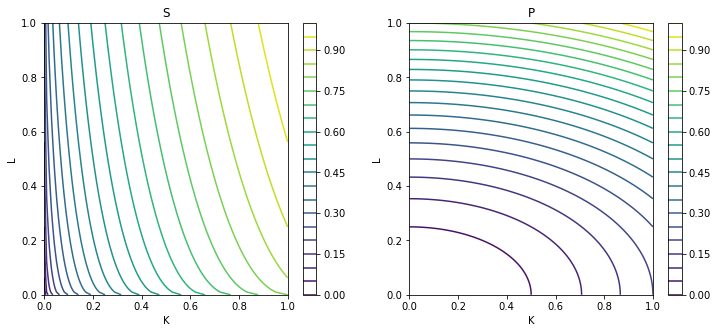

In [3]:
# Plot example production functions, showing some possible cases
ProdFunc(a=0.8, rho=0.5, mu=0.5, b=0.2, sigma=2, nu=2).plot()

Reward (with respect to K, L) is
$$\frac{S(K, L)}{1 + S(K, L)}R(P(K, L)) - \left(1-\frac{S(K, L)}{1 + S(K, L)}\right)d - rK - wL$$
or, rearranged
$$\frac{S(K, L)}{1 + S(K, L)}\big(R(P(K, L)) + d\big) - d - rK - wL$$
Jacobian is
$$\begin{pmatrix}
\frac{S_K}{(1 + S)^2} \big(R(P) + d\big) + \frac{S}{1 + S} R'(P)P_K - r
\\
\frac{S_L}{(1 + S)^2} \big(R(P) + d\big) + \frac{S}{1+S} R'(P)P_L - w
\end{pmatrix}$$

In [4]:
eps = 1e-10  # to help with numerical stability

def default_reward(p):
    return np.log(p+eps)

def default_reward_jac(p):
    return 1 / p


class SingleAgent:

    def __init__(self, d, r, w, R=None, R_jac=None, prodFunc=None):
        self.d = d
        self.r = r
        self.w = w
        self.prodFunc = ProdFunc() if prodFunc is None else prodFunc
        self.R = default_reward if R is None else R
        self.R_jac = default_reward_jac if R_jac is None else R_jac
        
        self.net_payoff = np.vectorize(self.net_payoff_)

    def net_payoff_(self, K, L):
        s = self.prodFunc.S_(K, L)
        proba = s / (1 + s)
        p = self.prodFunc.P_(K, L)
        return proba * self.R(p) - (1 - proba) * self.d - self.r * K - self.w * L
    
    def plot(self, Kmax=1.0, Lmax=1.0, nticks=100, ncontours=20, max_=None):
        KK, LL = np.meshgrid(np.linspace(0, Kmax, nticks), np.linspace(0, Lmax, nticks))
        plt.figure(figsize=(6, 5))
        plt.colorbar(plt.contour(KK, LL, self.net_payoff(KK, LL), ncontours))
        if max_ is not None:
            plt.scatter(*max_, marker='x')
            plt.title('Net payoff as function of K, L; optimum marked with x')
        else:
            plt.title('Net payoff as function of K, L')
        plt.xlabel('K')
        plt.ylabel('L')
        plt.show()

    def get_func(self):
        return lambda x: -self.net_payoff_(x[0], x[1])
    
    def get_jac(self):
        prod_jac = self.prodFunc.get_jac()
        def jac(x):
            p = self.prodFunc.P_(x[0], x[1])
            s = self.prodFunc.S_(x[0], x[1])
            proba = s / (1 + s)
            prod_jac_ = prod_jac(x)
            s_k = prod_jac_[0, 0]
            s_l = prod_jac_[0, 1]
            proba_k = s_k / (1 + s)**2
            proba_l = s_l / (1 + s)**2
            p_k = prod_jac_[1, 0]
            p_l = prod_jac_[1, 1]
            R = self.R(p)
            R_jac = self.R_jac(p)
            return -np.array([
                proba_k * (R + self.d) + proba * R_jac * p_k - self.r,
                proba_l * (R + self.d) + proba * R_jac * p_l - self.w
            ])
        return jac
    
    def solve(self, x0=(1, 1), verbose=1, plot=False):
        res = minimize(
            self.get_func(), x0, method='trust-constr',
            jac=self.get_jac(),
            bounds=Bounds([0.0, 0.0], [np.inf, np.inf]),
            options={
                'xtol': 1e-5,
                # 'maxiter': maxiter,
                'verbose': verbose
            }
        )
        if plot:
            plotsize = int(max(res.x) * 1.5) + 1
            self.plot(plotsize, plotsize, max_=res.x)
        return res

        

`gtol` termination condition is satisfied.
Number of iterations: 25, function evaluations: 17, CG iterations: 24, optimality: 2.03e-09, constraint violation: 0.00e+00, execution time: 0.056 s.
K: 25.23714406719623, L: 8.13278883923927
S: 4.16897094952714, P: 6.224354722316431


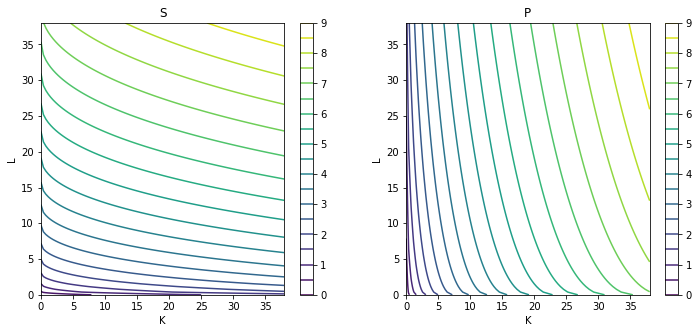

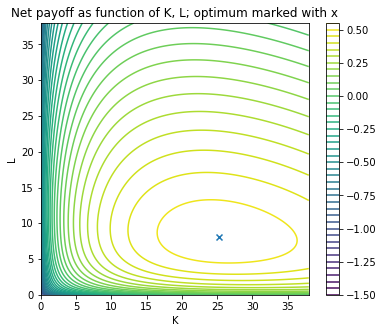

In [5]:
prodFunc = ProdFunc(a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)
problem = SingleAgent(
    d=1.0, r=0.02, w=0.03,
    prodFunc=prodFunc,
    # R=lambda x: x,
    # R_jac=lambda x: 1
)

res = problem.solve()

K_, L_ = tuple(res.x)
print(f'K: {K_}, L: {L_}')
print(f'S: {problem.prodFunc.S_(K_, L_)}, P: {problem.prodFunc.P_(K_, L_)}')

plotsize = int(max(K_, L_) * 1.5) + 1

prodFunc.plot(plotsize, plotsize)
problem.plot(plotsize, plotsize, 200, ncontours=40, max_=(K_, L_))

`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 19, CG iterations: 29, optimality: 2.69e-10, constraint violation: 0.00e+00, execution time: 0.099 s.
K: 26.826870873588643, L: 5.711781963042547
S: 7.31871253741723, P: 6.276915500955944


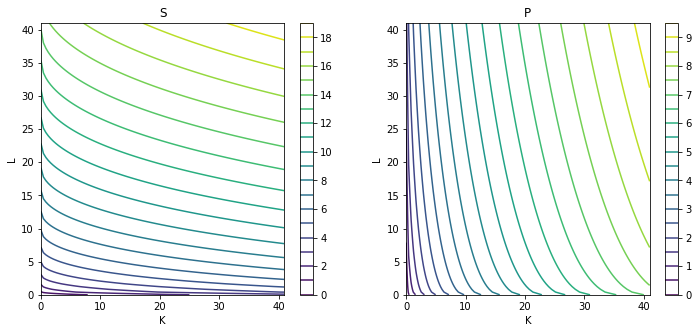

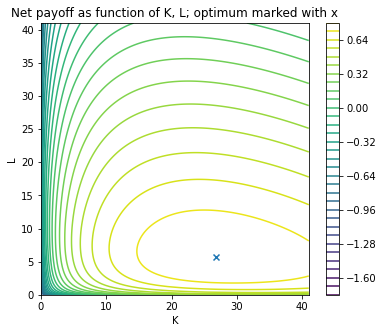

In [6]:
prodFunc = ProdFunc(A=2, a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)
problem = SingleAgent(
    d=1.0, r=0.02, w=0.03,
    prodFunc=prodFunc,
    # R=lambda x: x,
    # R_jac=lambda x: 1
)

res = problem.solve()

K_, L_ = tuple(res.x)
print(f'K: {K_}, L: {L_}')
print(f'S: {problem.prodFunc.S_(K_, L_)}, P: {problem.prodFunc.P_(K_, L_)}')

plotsize = int(max(K_, L_) * 1.5) + 1

prodFunc.plot(plotsize, plotsize)
problem.plot(plotsize, plotsize, 200, ncontours=40, max_=(K_, L_))

Can use this code to play around with various scenarios and see how firms would react to changes in those scenarios:

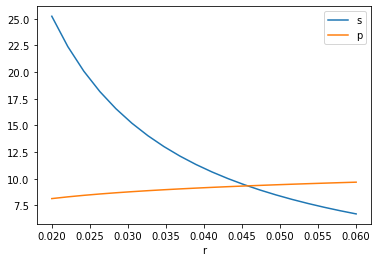

In [7]:
# do a little demo where we see how s and p change with change in r
prodFunc = ProdFunc(a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)
r_ = np.linspace(0.02, 0.06, 20)
s_, p_ = [], []

for r in r_:
    problem = SingleAgent(
        d=1.0, r=r, w=0.03,
        prodFunc=prodFunc,
        # R=np.sqrt,
        # R_jac=lambda x: 0.5 * x**-0.5
    )
    res = problem.solve(verbose=0)
    s_.append(res.x[0])
    p_.append(res.x[1])

plt.plot(r_, s_, label='s')
plt.plot(r_, p_, label='p')
plt.legend()
plt.xlabel('r')
plt.show()

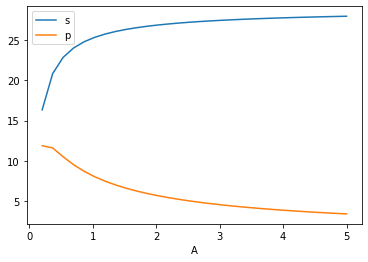

In [8]:
# what about change in A (safety productivity)?
A_ = np.linspace(0.2, 5.0, 30)
s_, p_ = [], []

for A in A_:
    prodFunc = ProdFunc(A=A, a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)
    problem = SingleAgent(
        d=1.0, r=0.02, w=0.03,
        prodFunc=prodFunc
    )
    res = problem.solve(verbose=0)
    s_.append(res.x[0])
    p_.append(res.x[1])

plt.plot(A_, s_, label='s')
plt.plot(A_, p_, label='p')
plt.legend()
plt.xlabel('A')
plt.show()

Let's think about theoretical aspects of this:

In [9]:
import sympy as sp
sp.init_printing()

In [10]:
# define variables and production functions
K, L, A, a, B, b, rho, mu, sigma, nu = sp.symbols('K L A a B b ρ μ σ ν')

S = A * (a * K**rho + (1-a) * L**rho)**(mu/rho)
P = B * (b * K**sigma + (1-b) * L**sigma)**(nu/sigma)

S, P

In [11]:
# Can easily compute derivatives
S_K = S.diff(K).simplify()
S_L = S.diff(L).simplify()
P_K = S.diff(K).simplify()
P_L = S.diff(L).simplify()

S_K, S_L, P_K, P_L

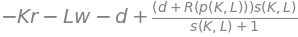

In [12]:
# define payoff function
r, w, d = sp.symbols('r w d')
s = sp.Function('s')(K, L)
p = sp.Function('p')(K, L)
R = sp.Function('R')(p)

payoff = (s / (1+s)) * (R + d) - d - r * K - w * L
payoff

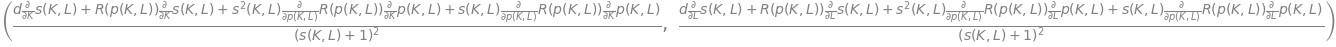

In [13]:
# solve first order conditions
sol = sp.solve([payoff.diff(K), payoff.diff(L)], (r, w))

r_ = sol[r].factor()
w_ = sol[w].factor()

r_, w_

These expressions are a bit of a mess, maybe better to write as

$$r = \frac{S_K}{(1 + S)^2} (R(P) + d) + \frac{S}{1+S} R'(P) P_K$$
$$w = \frac{S_L}{(1 + S)^2} (R(P) + d) + \frac{S}{1+S} R'(P) P_L$$
We can then think of things in terms of comparative statics. Problem is that different components of above equations move in different directions with change in $K$ or $L$.

Let's think about properties of $S$ function:

We know that $S$ is increasing in both $K$ and $L$. What about second derivatives?

In [14]:
S.diff(K, 2).simplify()

Sign of $S_{KK}$ depends on whether
$$aK^\rho (\mu - \rho) + (\rho - 1) (aK^\rho + (1-a)L^\rho ) \geq 0$$

If $\mu < 1$, that's equivalent to
$$\frac{K}{L} \leq \left(-\frac{1-\rho}{1-\mu}\frac{1-a}{a}\right)^{1/\rho},$$
i.e. if $\mu < 1$ and above inequality holds, then $S_{KK} \geq 0$.

For now, let's assume that we're in a region where $K,L$ are acting like substitutes (not complements), so $\rho < 1$. Then above condition will never hold, and $S_{KK} < 0$. Case where $K$ and $L$ are complements should also be looked at later.

Similar condition holds for $S_{LL}$: it's positive if
$$\frac{L}{K} \leq \left(-\frac{1-\rho}{1-\mu}\frac{a}{1-a}\right)^{1/\rho},$$
so in case with $\mu, \rho < 1$, we'll have $S_{LL} < 0$.

Analogous conditions hold for $P_{KK}$ and $P_{LL}$, of course. Also note that if $\mu$ (or $\nu$ for $P$) is $> 1$, then things will work backward.

Important thing is that in case with decreasing returns to scale and substitutable goods, can safely assume that all second derivatives are negative.

What about cross derivatives?

In [15]:
S.diff(K).diff(L).simplify()

Now relevant condition is sign of $\mu - \rho$.

If $\mu > \rho$, then $S_{KL} \geq 0$, o.w. $S_{KL} \leq 0$.

Analogous for $P_{KL}$, of course.

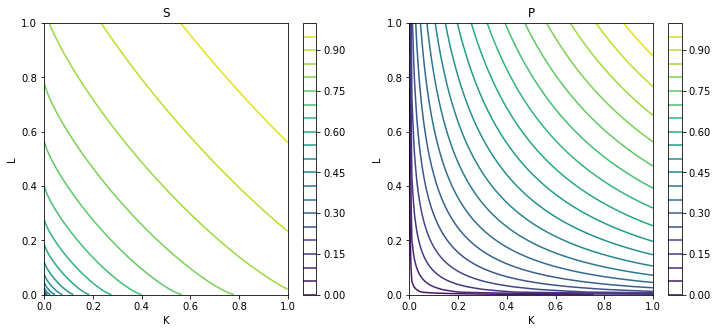

In [16]:
# You can kind of see this in the plots
# in left plot, more K is less helpful when L is high,
# in right plot, more K is more helpful when L is high
ProdFunc(a=0.5, rho=0.8, mu=0.2, b=0.5, sigma=0.2, nu=0.8).plot()

Model is a bit too complicated to say much about how optimum changes with change in various params (although I might be missing something). Options I see are to further simplify model (e.g. assume linear or C.D. production) or just embrace the computational route.

## The firm's problem with multiple agents

Suppose we have $N$ agents. In Nash equilibrium, each agent $i$ chooses $K_i$, $L_i$ to maximize
$$\pi_i(K_i, L_i) = \prod_{j} \frac{S_j}{1+S_j} R_i(P_i, P_{-i}) - \prod_{j} \left(1 - \frac{S_j}{1+S_j}\right) d_i - rK_i - wL_i$$
First order conditions will be essentially the same as before... although that was still a bit unwieldy to deal with. Can solve numerically, but is that the direction we want to go?

## Thinking about third party interventions

Ideas for some possible types of interventions:

1. Firms are required to pay a fixed cost for some safety-improving service.

2. Firms can hire "auditors," which have a positive effect on safety and possibly a negative effect on performance.

3. Firms are charged a penalty fee if they cause a disaster or if their safety is too low (should be more or less equivalent).

To model (1), just modify the payoff function to be
$$\pi_i(K_i, L_i) = \prod_{j} \frac{\tilde S_j}{1+\tilde S_j} R_i(P_i, P_{-i}) - \prod_{j} \left(1 - \frac{\tilde S_j}{1+\tilde S_j}\right) d_i - rK_i - wL_i - c,$$
where $\tilde S_j = S_j + s$, $s$ is the safety bonus, and $c$ is the cost of the mandatory safety service.

There are lots of ways I can think of to model (2), but one way is to change the production functions to be something like
$$\tilde S(K, L, I) = A \left(a_K K^\rho + a_L L^\rho + a_I I^\rho \right)^{\mu / \rho}$$
$$\tilde P(K, L, I) = B \left(b_K K^\sigma + b_L L^\sigma + b_I I^\sigma \right)^{\nu / \sigma}$$
where $a_K + a_L + a_I = b_K + b_L + b_I = 1$, and $I$ is the safety "inspectors" hired. Then the payoff function would be
$$\pi_i(K_i, L_i) = \prod_{j} \frac{\tilde S_j}{1+\tilde S_j} R_i(\tilde P_i, \tilde P_{-i}) - \prod_{j} \left(1 - \frac{\tilde S_j}{1+\tilde S_j}\right) d_i - rK_i - wL_i - cI_i,$$
where $c$ is the wage paid to safety inspectors.

To model (3), just modify the payoff function to be
$$\pi_i(K_i, L_i) = \prod_{j} \frac{S_j}{1+S_j} R_i(P_i, P_{-i}) - \prod_{j} \left(1 - \frac{S_j}{1+S_j}\right) d_i - \left(1 - \frac{S_i}{1+S_i}\right) c - rK_i - wL_i,$$
where $c$ is the fee for causing a disaster. Note this type of intervention doesn't make sense in single agent case.

Below is some code for the single agent case, assuming that (1) is implemented. It shouldn't be too hard to create numerical models & solutions for the other types of interventions, but I'm holding off on that for now.

In [17]:
class SingleAgentIntervention(SingleAgent):

    def __init__(self, d, r, w, s, c, R=None, R_jac=None, prodFunc=None):
        super().__init__(d, r, w, R, R_jac, prodFunc)
        self.s = s
        self.c = c
    
    def net_payoff_(self, K, L):
        s = self.prodFunc.S_(K, L) + self.s
        proba = s / (1 + s)
        p = self.prodFunc.P_(K, L)
        return proba * self.R(p) - (1 - proba) * self.d - self.r * K - self.w * L - self.c
    
    def get_jac(self):
        prod_jac = self.prodFunc.get_jac()
        def jac(x):
            p = self.prodFunc.P_(x[0], x[1])
            s = self.prodFunc.S_(x[0], x[1]) + self.s
            proba = s / (1 + s)
            prod_jac_ = prod_jac(x)
            s_k = prod_jac_[0, 0]
            s_l = prod_jac_[0, 1]
            proba_k = s_k / (1 + s)**2
            proba_l = s_l / (1 + s)**2
            p_k = prod_jac_[1, 0]
            p_l = prod_jac_[1, 1]
            R = self.R(p)
            R_jac = self.R_jac(p)
            return -np.array([
                proba_k * (R + self.d) + proba * R_jac * p_k - self.r,
                proba_l * (R + self.d) + proba * R_jac * p_l - self.w
            ])
        return jac

Before intervention:
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 16, CG iterations: 24, optimality: 7.73e-11, constraint violation: 0.00e+00, execution time: 0.05 s.


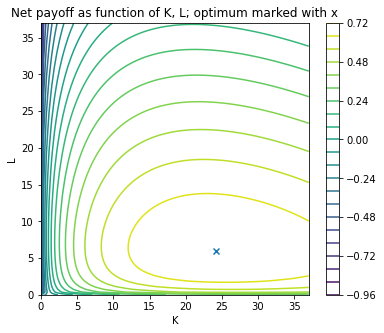

S = 3.643550668749731, P = 5.947194885082178

After zero-cost intervention:
`gtol` termination condition is satisfied.
Number of iterations: 25, function evaluations: 16, CG iterations: 25, optimality: 1.21e-10, constraint violation: 0.00e+00, execution time: 0.083 s.


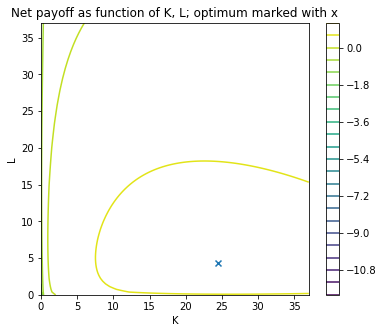

S = 4.217813868172837, P = 5.866497464629079


In [18]:
prodFunc = ProdFunc(a=0.2, rho=0.5, mu=0.6, b=0.8, sigma=0.5, nu=0.6)

print('Before intervention:')
problem = SingleAgentIntervention(
    d=0.1, r=0.02, w=0.03,
    s=0, c=0,
    prodFunc=prodFunc
)
max_ = problem.solve(plot=True).x
print(f'S = {problem.prodFunc.S_(*max_) + problem.s}, P = {problem.prodFunc.P_(*max_)}')

print('\nAfter zero-cost intervention:')
problem = SingleAgentIntervention(
    d=0.1, r=0.02, w=0.03,
    s=1, c=0.00,
    prodFunc=prodFunc
)
max_ = problem.solve(plot=True).x
print(f'S = {problem.prodFunc.S_(*max_) + problem.s}, P = {problem.prodFunc.P_(*max_)}')


After intervention, agents actually respond by reducing spending on both safety and performance. Could play around much more with this to see various scenarios.

One thing to note is that at least in single-agent game, changing cost parameter $c$ doesn't modify optimal strategy at all. However, if we introduce an IR condition (agents will not participate if expected payoff is negative), then having a high $c$ would exclude some players from participating. Ideally, we want a mechanism that excludes high-risk players.